In [41]:
import pandas as pd
import numpy as np
import itertools
import plotly.graph_objects as go
import plotly.io as pio
pio.kaleido.scope.default_format = "pdf"
from matplotlib.colors import ListedColormap
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from plotly.offline import plot
import itertools
import sys
#sys.path.insert(0, '/home/data4/jh/data/tools/customized/tadtools/tadtool_pkg')
import utils as ut
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm
from scipy.stats import mannwhitneyu
from itertools import chain

In [37]:
def extract(a,dense_pixel_cis):
    return (dense_pixel_cis.iloc[:,1]>=a[0]) & (dense_pixel_cis.iloc[:,4]>=a[0]) & (dense_pixel_cis.iloc[:,2]<=a[1]) & (dense_pixel_cis.iloc[:,5]<=a[1])

In [42]:
A_type = pd.read_csv('./data/A2_type.bed', sep='\t')
B_type = pd.read_csv('./data/B2_type.bed', sep='\t')

In [43]:
A_types = A_type.groupby(A_type.type)
types_keys = A_type.type.unique()
A_types = [A_types.get_group(x) for x in types_keys]

In [44]:
B_types = B_type.groupby(B_type.type)
types_keys = B_type.type.unique()
B_types = [B_types.get_group(x) for x in types_keys]

In [41]:
def extract_chr(chrstr,type_tad):
    dense_pixel = pd.read_csv(f'../inorbetween/{chrstr}.bedpe',header=None,sep='\t')
    dense_pixel_cis = dense_pixel.loc[dense_pixel.iloc[:,3]==chrstr,:].reindex()
    type_tad_chr = type_tad.loc[type_tad.iloc[:,0]==chrstr,['start','end']].to_numpy()
    union_tad = []
    for row in type_tad_chr:
        if union_tad and union_tad[-1][1] >= row[0]-1:
            union_tad[-1][1] = max(union_tad[-1][1],row[1])
        else:
            union_tad.append([row[0],row[1]])
    chr_result = list(map(extract,union_tad,itertools.repeat(dense_pixel_cis, len(union_tad))))
    chr_all = list(map(bool,sum(chr_result)))
    return dense_pixel_cis.loc[chr_all,:].reindex()

In [42]:
## chrstr extract from tad.bed
def write_interaction(tad):
    name = tad.type.reset_index().type[0]
    result_list = []
    for chrstr in tad.iloc[:,0].unique():
        result_list.append(extract_chr(chrstr,tad))
    cis_tad = pd.concat(result_list, axis=0, join='outer', ignore_index=True, keys=None,
              levels=None, names=None, verify_integrity=False, copy=True)
    cis_tad.to_csv(f'./results/{name}_cis_TAD.bedpe',index=False,header=False,sep='\t')
    return cis_tad

In [5]:
A_interactions = []
n_types = len(A_types)
i = 0
for type_ in A_types:
    A_interactions.append(write_interaction(type_))
    print(f'{i} / {n_types}')
    i+=1

NameError: name 'A_types' is not defined

In [18]:
def read_interaction(file):
    return pd.read_csv(file,sep='\t',header=None)

import glob

files = glob.glob('./results/A*.bedpe')
A_interactions = list(map(read_interaction,files))
B_files = glob.glob('./results/B*.bedpe')
B_interactions = list(map(read_interaction,B_files))

In [3]:
def remove_dup(cis_tad):
    dense = pd.DataFrame()
    dense['loc1'] = cis_tad.iloc[:,[0,1,2]].apply(lambda row: '_'.join(map(str,row)),axis=1)
    dense['loc2'] = cis_tad.iloc[:,[3,4,5]].apply(lambda row: '_'.join(map(str,row)),axis=1)
    dense['value'] = cis_tad.iloc[:,7]
    dense_nodiag = dense.iloc[np.where(dense['loc1']!=dense['loc2'])[0],:]
    return dense_nodiag

In [7]:
files

['./results/A01_cis_TAD.bedpe',
 './results/A10_cis_TAD.bedpe',
 './results/A11_cis_TAD.bedpe',
 './results/A00_cis_TAD.bedpe']

In [19]:
nodiags = list(map(remove_dup,A_interactions))
A_RR = nodiags[3]
A_CC = nodiags[2]
A_RC = nodiags[0].append(nodiags[1],ignore_index=True)

A_nodiags_type = [A_RR,A_RC,A_CC]
A_name_list = ['ARR','ARC','ACC']

In [20]:
nodiags = list(map(remove_dup,B_interactions))
B_RR = nodiags[2]
B_CC = nodiags[3]
B_RC = nodiags[0].append(nodiags[1],ignore_index=True)

S_nodiags_type = [B_RR,B_RC,B_CC]
S_name_list = ['BRR','BRC','BCC']

In [21]:
def group_loc(nodiag_tad):
    return nodiag_tad.groupby(['loc1']).sum()
S_nodiags_grouped = list(map(group_loc,S_nodiags_type))
A_nodiags_grouped = list(map(group_loc,A_nodiags_type))

In [22]:
S_value_list = list(map(lambda x: x['value'].to_numpy(),S_nodiags_grouped))
A_value_list = list(map(lambda x: x['value'].to_numpy(),A_nodiags_grouped))

In [23]:
import statistics
A_remove_na = list(map(np.nan_to_num,A_value_list))
A_sorted_index = np.flip(np.argsort(list(map(sum,A_remove_na))))

In [36]:
names = np.array(["A-RR","A-RC", "A-CC","B-RR","B-RC", "B-CC"])
name_column = np.repeat(names, [len(x) for x in A_remove_na]+[len(x) for x in S_remove_na], axis=0)
A_values_ = itertools.chain(*A_remove_na)
B_values_ = itertools.chain(*S_remove_na)
data={'TAD-TAD interaction':list(A_values_)+list(B_values_),'Type':name_column}
df=pd.DataFrame(data)

In [37]:
df['Type'] = pd.Categorical(df['Type'], ['A-RR','B-RR','A-RC','B-RC','A-CC','B-CC'])
df.sort_values("Type")

,TAD-TAD interaction,Type
0,0.269339,A-RR
3553,0.427595,A-RR
3552,0.423833,A-RR
3551,0.444741,A-RR
3550,0.432421,A-RR
...,...,...
23276,0.323560,B-CC
23277,0.371513,B-CC
23278,0.337993,B-CC
23271,0.286672,B-CC


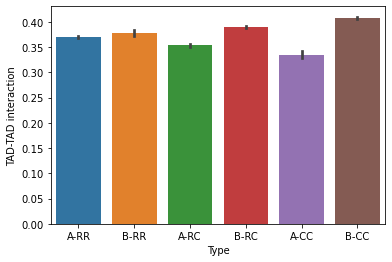

In [38]:
sns.barplot(x="Type", y="TAD-TAD interaction", data=df)
plt.savefig('results/TAD-TAD_interaction.pdf', bbox_inches='tight')

In [19]:
A_remove_na

[array([0.26933931, 0.32406895, 0.31760511, ..., 0.31775614, 0.33134459,
        0.26919564]),
 array([0.23005753, 0.24319485, 0.26092254, ..., 0.2478189 , 0.1642599 ,
        0.15857155]),
 array([0.33824552, 0.31466651, 0.32441445, 0.22186428, 0.1853577 ,
        0.2016198 , 0.2276109 , 0.2311484 , 0.2332662 , 0.2491487 ,
        0.2530336 , 0.2505987 , 0.2566685 , 0.2564815 , 0.2177732 ,
        0.201028  , 0.26941944, 0.31974684, 0.36725945, 0.3206633 ,
        0.42569363, 0.39073398, 0.39581234, 0.37350394, 0.36528339,
        0.37454969, 0.37775245, 0.36273875, 0.35084874, 0.37643046,
        0.37538439, 0.3096127 , 0.28433911, 0.20690678, 0.1464696 ,
        0.2019423 , 0.2699897 , 0.2463486 , 0.2501387 , 0.2692876 ,
        0.2802379 , 0.2375445 , 0.2235223 , 0.19371367, 0.23069148,
        0.28519203, 0.2879232 , 0.30521882, 0.32413163, 0.31103352,
        0.32979356, 0.36341137, 0.31704703, 0.30958553, 0.30243099,
        0.3054235 , 0.29741584, 0.26443251, 0.18212874, 0.1235

In [31]:
S_remove_na = list(map(np.nan_to_num,S_value_list))
S_sorted_index = np.flip(np.argsort(list(map(sum,S_remove_na))))

In [24]:
vll = np.array(A_value_list, dtype=object)[A_sorted_index]
sorted_name_list = np.array(A_name_list, dtype=object)[A_sorted_index]

In [25]:
S_vll = np.array(S_value_list, dtype=object)[S_sorted_index]
S_sorted_name_list = np.array(S_name_list, dtype=object)[S_sorted_index]

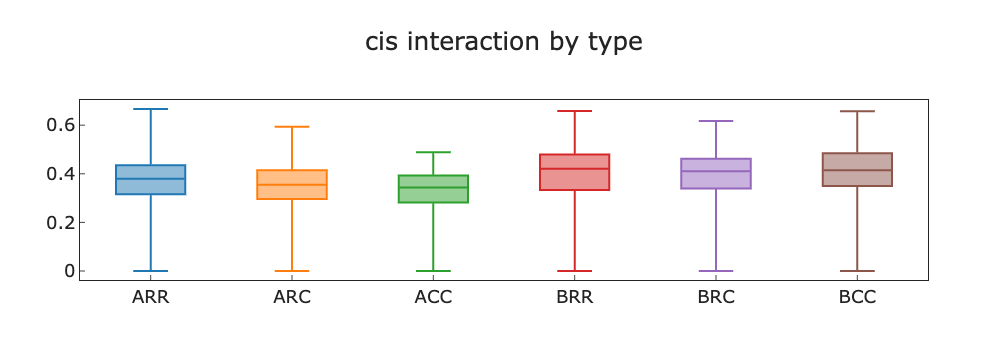

In [25]:
fig = go.Figure()

for i in range(6):
    fig.add_trace(go.Box(
    y=np.concatenate((A_remove_na, S_remove_na), axis=None, dtype=object)[i],
    name=np.concatenate((A_name_list,S_name_list),axis=None, dtype=object)[i],
    jitter=0.3,
    boxpoints=False
    ))

fig.update_layout(template='simple_white',title_text='cis interaction by type',xaxis = dict(showgrid=False, ticks='inside',mirror=True,showline=True),
                yaxis = dict(showgrid=False, ticks='inside',mirror=True,showline=True),
                font=dict(size=18),
                 title_x=0.5,
                 showlegend=False)
#fig.write_image('./results/sortsum_interactiontadbytype_clean.pdf')


In [28]:
value_list = list(chain(*zip(A_value_list,S_value_list)))

interaction_pair = list(itertools.combinations(value_list,2))

from scipy.stats import mannwhitneyu
ps = []
for pair in interaction_pair:
    stat, p = mannwhitneyu(pair[0], pair[1])
    ps.append(p)

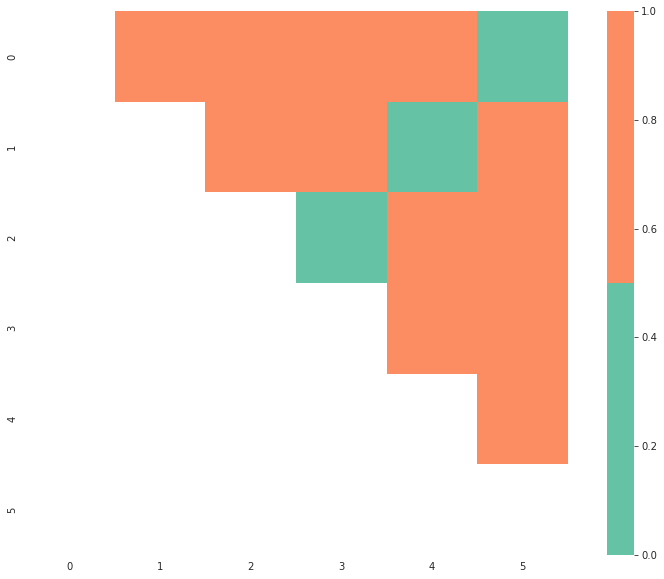

In [29]:
def plot_sig(ps):
    arr = np.zeros((6,6))
    indices = np.triu_indices(6,1)
    arr[indices] = ps
    arr_sig = np.where(arr<0.05,1,0)
    #ps_if_arr = -np.log10(arr)
    mask = np.zeros_like(arr) 
    mask[np.tril_indices_from(mask)] = True
    tab10 = cm.get_cmap('tab10')
    colors = ["white",tab10(3)]
    cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
    cmap2 = sns.color_palette("Set2",2)

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(14, 10))
        #ax = sns.heatmap(ps_if_arr, mask=mask, vmin=0, vmax=5, square=True,cmap=cmap1)
        ax = sns.heatmap(arr_sig, mask=mask, square=True,cmap=cmap2)
        f.savefig(f'./results/tt_interaction_sig.pdf',bbox_inches='tight')
plot_sig(ps)

In [58]:
data_all = pd.read_csv('./data/TAD_ChIP_strength_fpkm_size_E1_interaction_twoborerexpression_innerfpkm.tsv',sep='\t')
data_all = data_all.rename(columns={'#chrom': 'chrom'})
type_all = A_type.append(B_type,ignore_index=True)
data_all_type = pd.merge(data_all,type_all,on=['chrom','start','end'],how='inner')
data_all_type['expression'] = pd.to_numeric(data_all_type['inner_fpkm'],errors='coerce')
data_all_type = data_all_type.dropna()

In [63]:
# data_all_type['type'].replace('A10', 'A01', inplace=True)
# data_all_type['type'].replace('B10', 'B01', inplace=True)
# data_all_type['compartmental states']=data_all_type['type'].str.slice(stop=1)
# data_all_type['boundary states']=data_all_type['type'].str.slice(start=1)
# data_all_type['type'] = pd.Categorical(data_all_type['type'], ['A00','B00','A01','B01','A11','B11'])
data_all_type_sorted = data_all_type.sort_values("type").reset_index()

In [70]:
import numpy as np
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [49]:
data_all_type['compartmental states']=data_all_type['type'].str.slice(stop=1)

/tmp/ipykernel_3509895/1947620457.py:3: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "family" which is no longer supported as of 3.3 and will become an error two minor releases later



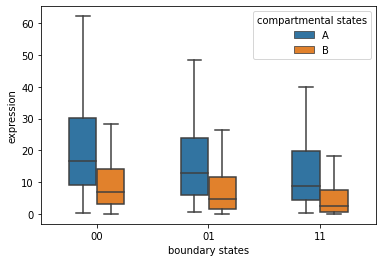

In [74]:
sns.boxplot(x="boundary states", y="expression", hue="compartmental states",
            data=data_all_type_sorted,showfliers=False, width=0.5)
plt.savefig('./results/withintadexpression_split.pdf',bbox_inches='tight',family='sans')

(0.0, 60.0)

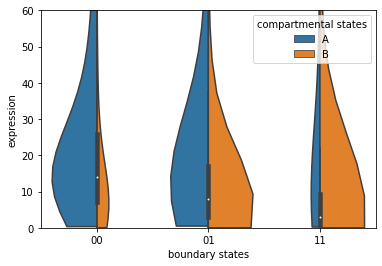

In [84]:
ax = sns.violinplot(x="boundary states", y="expression", hue="compartmental states",
                    data=data_all_type_sorted, split=True,
                    scale="count", cut=0)
ax.set_ylim(0,60)

In [82]:
any(data_all_type_sorted['expression']<0)

False

/tmp/ipykernel_3509895/2344190418.py:3: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "family" which is no longer supported as of 3.3 and will become an error two minor releases later



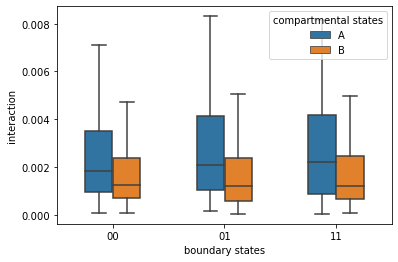

In [85]:
sns.boxplot(x="boundary states", y="interaction", hue="compartmental states",
            data=data_all_type_sorted,showfliers=False, width=0.5)
plt.savefig('./results/bounary_interaction_split.pdf',bbox_inches='tight',family='sans')

/tmp/ipykernel_3509895/4267219982.py:3: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "family" which is no longer supported as of 3.3 and will become an error two minor releases later



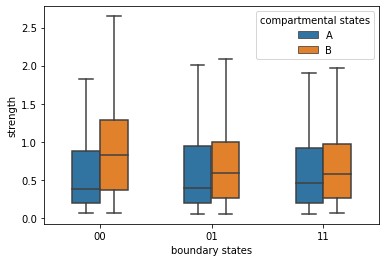

In [86]:
sns.boxplot(x="boundary states", y="strength", hue="compartmental states",
            data=data_all_type_sorted,showfliers=False, width=0.5)
plt.savefig('./results/boundary_strength_split.pdf',bbox_inches='tight',family='sans')

/tmp/ipykernel_3509895/3793171119.py:3: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "family" which is no longer supported as of 3.3 and will become an error two minor releases later



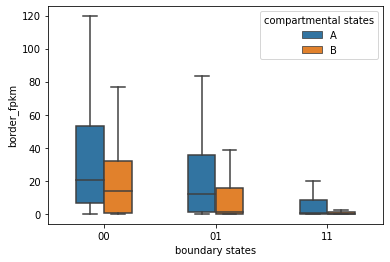

In [87]:
sns.boxplot(x="boundary states", y="border_fpkm", hue="compartmental states",
            data=data_all_type_sorted,showfliers=False, width=0.5)
plt.savefig('./results/expression_border_split.pdf',bbox_inches='tight',family='sans')

/tmp/ipykernel_3509895/2149966261.py:3: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "family" which is no longer supported as of 3.3 and will become an error two minor releases later



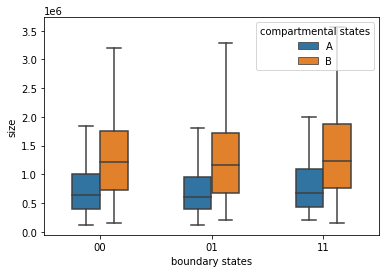

In [88]:
sns.boxplot(x="boundary states", y="size", hue="compartmental states",
            data=data_all_type_sorted,showfliers=False, width=0.5)
plt.savefig('./results/size_split.pdf',bbox_inches='tight',family='sans')

In [57]:
def group_list(df,x):
    return df.groupby('type')[x].apply(list)

def plot_sig(ps,name):
    
    arr = np.zeros((6,6))
    indices = np.triu_indices(6,1)
    arr[indices] = ps
    arr_sig = np.where(arr<0.05,1,0)
    #ps_if_arr = -np.log10(arr)
    mask = np.zeros_like(arr) 
    mask[np.tril_indices_from(mask)] = True
    tab10 = cm.get_cmap('tab10')
    colors = ["white",tab10(3)]
    cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
    cmap2 = sns.color_palette("Set2",2)

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(14, 10))
        #ax = sns.heatmap(ps_if_arr, mask=mask, vmin=0, vmax=5, square=True,cmap=cmap1)
        ax = sns.heatmap(arr_sig, mask=mask, square=True,cmap=cmap2)
        f.savefig(f'./results/{name}_sig.pdf',bbox_inches='tight')

def save_sig(ps,name):
    
    arr = np.zeros((6,6))
    indices = np.triu_indices(6,1)
    arr[indices] = ps

    with open(f'results/{name}_sig.tsv', 'wb') as f:
        for line in np.matrix(arr):
            np.savetxt(f, line, fmt='%.4f')

for name in ['inner_fpkm','interaction','strength','border_fpkm','size']:
    value_list = group_list(data_all_type_sorted,name)
    pairs = list(itertools.combinations(value_list,2))
    ps = []
    for pair in pairs:
        stat, p = mannwhitneyu([float(x) for x in pair[0]], [float(x) for x in pair[1]])
        ps.append(p)
    #plot_sig(ps,name)
    save_sig(ps, name)